In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_kawasan_par = pd.read_csv("../../data/jml_tenaga_kerja_kawasan_pariwisata__jenis_kelamin_2014-2017/data.jabarprov.go.id/disparbud-od_jml_tk_kawasan_pariwisata__jk_data.csv")
data_jasa_info_par = pd.read_csv("../../data/jumlah_tenaga_kerja_jasa_info_pariwasata__jenis_kelamin_2016-2019/data.jabarprov.go.id/disparbud-od_jml_tk_jasa_infms_pariwisata__jk_data.csv")
data_jasa_konsultan_par = pd.read_csv("../../data/jumlah_tenaga_kerja_jasa_konsultan_pariwasata__jenis_kelamin_2016-2019/data.jabarprov.go.id/disparbud-od_jml_tk_jasa_konsultan_pariwisata__jk_data.csv")
data_usaha_perjalanan_par = pd.read_csv("../../data/jumlah_tenaga_kerja_ush_perjalanan_pariwisata_2014-2019/data.jabarprov.go.id/disparbud-od_jumlah_tenaga_kerja_bidang_jasa_pariwisata_data.csv")

In [5]:
data_kawasan_par.head()

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jenis_kelamin,jumlah_tenaga_kerja,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,PRIA,0.0,ORANG,2014
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,WANITA,0.0,ORANG,2014
2,3,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,PRIA,0.0,ORANG,2014
3,4,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,WANITA,0.0,ORANG,2014
4,5,32,JAWA BARAT,3203,KABUPATEN CIANJUR,PRIA,0.0,ORANG,2014


In [9]:
data_jasa_info_par.head()

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jenis_kelamin,jumlah_tenaga_kerja,satuan,tahun
0,0,32,JAWA BARAT,3201,KABUPATEN BOGOR,PRIA,0,ORANG,2016
1,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,WANITA,0,ORANG,2016
2,2,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,PRIA,0,ORANG,2016
3,3,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,WANITA,0,ORANG,2016
4,4,32,JAWA BARAT,3203,KABUPATEN CIANJUR,PRIA,5,ORANG,2016


In [36]:
data_jasa_konsultan_par["jumlah_tenaga_kerja"].replace("s", 0, inplace=True)
data_jasa_konsultan_par["jumlah_tenaga_kerja"] = data_jasa_konsultan_par["jumlah_tenaga_kerja"].astype(
    int)

In [37]:
kawasan_sum = pd.DataFrame(data_kawasan_par.groupby("tahun")["jumlah_tenaga_kerja"].sum())
info_sum = pd.DataFrame(data_jasa_info_par.groupby("tahun")["jumlah_tenaga_kerja"].sum())
konsultan_sum = pd.DataFrame(data_jasa_konsultan_par.groupby("tahun")["jumlah_tenaga_kerja"].sum())
perjalanan_sum = pd.DataFrame(data_usaha_perjalanan_par.groupby("tahun")["jumlah_tenaga_kerja"].sum())

In [52]:
concat_sum = pd.concat([kawasan_sum, info_sum, konsultan_sum, perjalanan_sum], axis=1)
concat_sum.columns = ["kawasan", "info", "konsultan", "perjalanan"]
concat_sum["total"] = concat_sum.replace(np.nan, 0)[
    "kawasan"] + concat_sum.replace(np.nan, 0)["info"] + concat_sum.replace(np.nan, 0)["konsultan"] + concat_sum.replace(np.nan, 0)["perjalanan"]
concat_sum

,kawasan,info,konsultan,perjalanan,total
tahun,,,,,
2014,363.0,NaN,4,749,1116.0
2015,495.0,NaN,4,807,1306.0
2016,1918.0,22.0,12,1120,3072.0
2017,1959.0,23.0,14,1257,3253.0
2018,NaN,34.0,19,1546,1599.0
2019,NaN,20.0,49,1913,1982.0


<AxesSubplot:xlabel='tahun'>

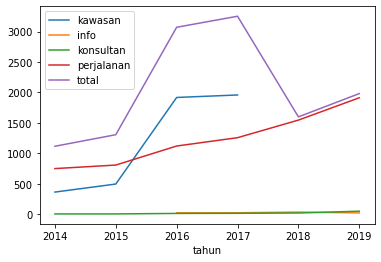

In [53]:
concat_sum.plot()

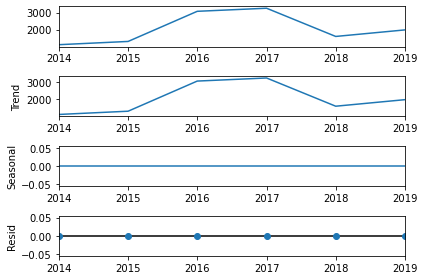

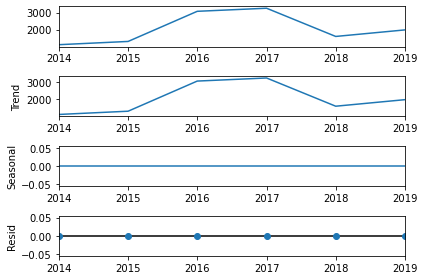

In [68]:
tsa_data = pd.DataFrame(concat_sum["total"])
tsa_data.index = pd.to_datetime(concat_sum.index, format="%Y")

seasonal_decompose(tsa_data, model='additive').plot()

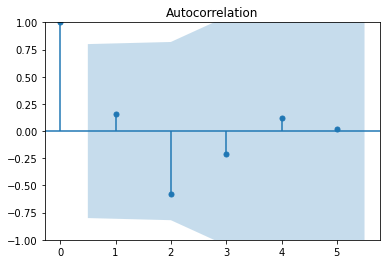

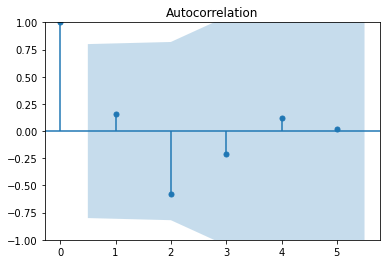

In [73]:
# ma = 1?
plot_acf(tsa_data)

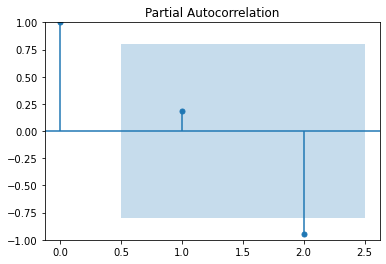

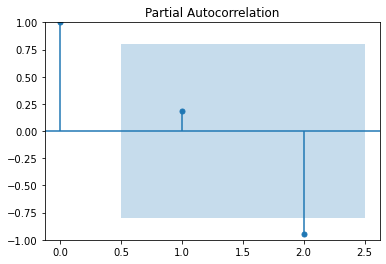

In [77]:
# ar = 2
plot_pacf(tsa_data, lags=2)

In [115]:
# adfuller test, d = 1

p_value = adfuller(tsa_data["total"].diff().diff().dropna())[1]
print("p-value: ", p_value)

p-value:  0.48053436440723


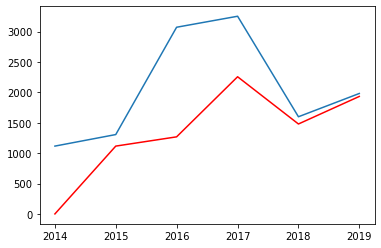

In [274]:
# tsa_data.drop("forecast", axis=1, inplace=True)
model_1 = ARIMA(tsa_data, order=(2, 1, 1))
model_1_fit = model_1.fit()

plt.plot(tsa_data)
plt.plot(model_1_fit.fittedvalues, color='red')

In [275]:
y_pred = model_1_fit.fittedvalues
y_true = tsa_data["total"]

mse = mean_squared_error(list(y_true), list(y_pred))
print("RMSE: ", np.sqrt(mse))

RMSE:  961.1787828254116


<AxesSubplot:>

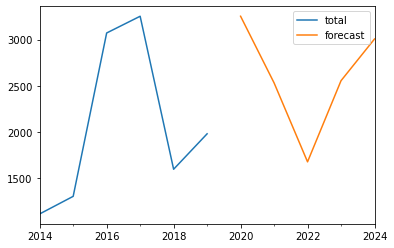

In [257]:
df_forecast = pd.DataFrame(model_1_fit.forecast(5))
df_forecast.columns = ["forecast"]
df_forecast["forecast"] = df_forecast["forecast"].astype(int)
df_forecast.index = pd.to_datetime(df_forecast.index, format="%Y")

concat_df = pd.concat([tsa_data, df_forecast], axis=1)
concat_df.plot()

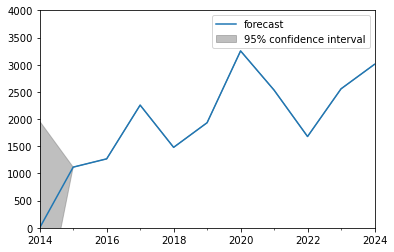

In [277]:
plot_predict(model_1_fit, start=0, end=10)
plt.ylim(0, 4000)
plt.show()